# ML2021spring HW\#1

- Author : Liang-Cheng Chen 陳亮丞
- ID     : r08323022
- Email  : <r08323022@ntu.edu.tw>


## README

### References

I refer to the sample code provided by the course TA, Heng-Jui Chang.
(the Colab notebook link is [here](https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb#scrollTo=k-onQd4JNA5H))

Basically I leverage the same `plot_learning_curve`, `plot_pred`, and `save_predict` function setups used in the sample code.

Also, I keep the same `target_only` option as the sample code when building `Dataset` and `DataLoader` objects. This option provides convienience when conducting experiments on features selection. (e.g. LASSO and Ridge regression)

### Feature
I tried different features for training.

In the final version, I use the columns that have higher correlation with the target (`cor > 0.75`).

I provide the details and result in Appendix.

### Model
I build a neural network which has one hidden layer and uses 32 neurons.

I choose `Adam` for optimizer and use `MSELoss` with L2 regularization. (I also include the L1 regularization for experiments).

The other model details and building codes will be provided in following chunks.

## Modules





In [49]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Fix random seed for reproduction
myseed = 123  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## Download Data

In [50]:
!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 31.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 10.2MB/s]


## Build Dataset and DataLoader

### Dataset
I follow the sample code setups to build the `Dataset` and `DataLoader`. However, I use different way to split the train/validation data.

Originally the data was split by simply calculate the remainder (mod 10). Here I first shuffle the order of the rows to avoid potential order pattern.


The `Covid19Dataset` class will help:

- read `.csv` file
- features selection
- train/validate split with shuffle


In [51]:
class Covid19Dataset(Dataset):

    def __init__(self, path, mode='train', target_only=False):

        self.mode = mode

        with open(path, 'r') as fin:
            data = list(csv.reader(fin))

            # we delete first row: column names, and the first column: id
            # convert str to num
            data = np.array(data[1:])[:, 1:].astype(float)

        
        # Features Selection

        if target_only == False:
            # use full columns as features
            fts = list(range(93))
            
        else:
            # self-selected features
            # here I choose columns that have high correlation with target

            states_cols = list(range(40))
            # test_positive = [57, 75]
            high_cols = [40, 41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79]
            fts = states_cols + high_cols

        
        if mode == 'test':
            # Testing Data
            # shape: (893, 93), without day 3 positive cases
            data = data[:, fts]
            self.data = torch.FloatTensor(data)

        else:
            # Training and Validation Data
            # (2700, 94)

            # TODO: How to cope with data order problem ?
            #  (1) Random draw from original data
            #  (2) Shuffle

            # First try (2) shuffle
            idxx = np.arange(len(data))
            np.random.shuffle(idxx)
            data = data[idxx]


            target = data[:, -1]
            data   = data[:, fts]


            if mode == 'train':
                index = [i for i in range(len(data)) if i % 10 != 3]
            elif mode == 'valid':
                index = [i for i in range(len(data)) if i % 10 == 3] 

            self.data   = torch.FloatTensor(data[index])
            self.target = torch.FloatTensor(target[index])


        self.dim = self.data.shape[1]
        
        print(f"Finished reading {self.mode:5s} set, ({len(self.data):5d} obs., {self.dim:3d} cols)")

    
    def __getitem__(self, index):

        if self.mode in ['train', 'valid']:
            return self.data[index], self.target[index]

        else:
            return self.data[index]


    def __len__(self):

        return len(self.data)


In [52]:
# test for Dataset object
tester = Covid19Dataset(path='./covid.train.csv', mode='train')
tester2 = Covid19Dataset('./covid.test.csv', 'test')

Finished reading train set, ( 2430 obs.,  93 cols)
Finished reading test  set, (  893 obs.,  93 cols)


### DataLoader

Dataloader helps load data with self-assigned:
- `batch_size`
- `shuffle` 


In [53]:
def load(path, mode, batch_size, target_only=False):
    dataset = Covid19Dataset(path=path, mode=mode, target_only=target_only)
    
    dataloader = DataLoader(
        dataset, batch_size, shuffle= (mode == 'train')
    )
    return dataloader

In [54]:
# test for dataloader
tmp = load('./covid.train.csv', 'train', 128)
tmp.dataset.data.shape

Finished reading train set, ( 2430 obs.,  93 cols)


torch.Size([2430, 93])

## Model Training

### Network

Here use `Pytorch.NN` class to build up a Neural Network Model.

This part will include:

- Create Network with provided number of layers, neurons
- Activation function
- Loss function

In [55]:
class Net(nn.Module):

    def __init__(self, input_dim):
        super().__init__()

        # Hidden Layers, Neurons, Activation Func
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Loss function
        self.criterion = nn.MSELoss()


    def forward(self, x):
        
        return self.net(x).squeeze(1)


    def cal_loss(self, pred, target):
        '''
        Calculate loss with L2-regularization.
        Add L1-regularization for possible use.
        '''
        # L2
        l2_lambda = 0.001
        l2_reg = 0

        # L1
        # l1_lambda = 0.001
        # l1_reg = 0
        
        for param in model.parameters():
            l2_reg += torch.sum(param.pow(2))
            # l1_reg += torch.sum(param.abs())

        loss = self.criterion(pred, target) + l2_lambda * l2_reg
        # loss += l1_lambda * l1_reg

        return loss

### Training

This part provides the training code block

In [56]:
# First read data
train_set = load('./covid.train.csv', 'train', 256, target_only=True)
valid_set = load('./covid.train.csv', 'valid', 256, target_only=True)
test_set = load('./covid.test.csv', 'test', 256, target_only=True)

Finished reading train set, ( 2430 obs.,  54 cols)
Finished reading valid set, (  270 obs.,  54 cols)
Finished reading test  set, (  893 obs.,  54 cols)


In [57]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'gpu'

get_device()

'cuda'

In [58]:
# setups
n_epochs = 3000
device = get_device()

min_mse = 100
loss_record = {"train":[], "valid":[]}
early_stop = 300
early_count = 0
epoch = 0

# initialize model and optimizer
model = Net(train_set.dataset.dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


while epoch < n_epochs:
    
    # Actual Training Part
    model.train() # set to train mode

    for x, y in train_set:

        optimizer.zero_grad()               # remove previous gradient
        x, y = x.to(device), y.to(device)
        pred = model(x)                     # prediction
        mse_loss = model.cal_loss(pred, y)
        mse_loss.backward()                 # loss gradient
        optimizer.step()                    # update weights

        # track training loss, save into record
        loss_record['train'].append(mse_loss.detach().cpu().item())


    # Validation Part
    model.eval()
    val_loss = 0
    for x, y in valid_set:
        x, y = x.to(device), y.to(device)
        
        # stop calculating gradient when validating
        with torch.no_grad():
            pred = model(x)
            val_mse_loss = model.cal_loss(pred, y)
        val_loss += val_mse_loss.detach().cpu().item() * len(x)

    val_mse = val_loss / len(valid_set.dataset)


    # Early Stop

    # if validation mse does not improve for n epochs
    # then stop training to avoid overfitting.

    if val_mse < min_mse:
        
        min_mse = val_mse
        early_count = 0 # reset early count

        torch.save(model.state_dict(), "./model.pth") # save best model

        best_model = model

        print("[{:4d}] \t Train loss: {:.4f} \t Val loss: {:.4f}"
        .format(epoch + 1, mse_loss, min_mse))
    else:
        early_count += 1

    epoch += 1
    loss_record['valid'].append(val_mse)

    if early_count > early_stop:

        break

print(f'Finished training after {epoch} epochs')


[   2] 	 Train loss: 84.9418 	 Val loss: 87.8652
[   3] 	 Train loss: 49.7733 	 Val loss: 34.8438
[   4] 	 Train loss: 14.3629 	 Val loss: 13.8584
[   5] 	 Train loss: 14.5645 	 Val loss: 12.3249
[   8] 	 Train loss: 8.9651 	 Val loss: 11.7077
[   9] 	 Train loss: 8.8233 	 Val loss: 11.2547
[  10] 	 Train loss: 11.7360 	 Val loss: 11.0211
[  11] 	 Train loss: 10.4217 	 Val loss: 10.8954
[  12] 	 Train loss: 11.8949 	 Val loss: 10.7398
[  13] 	 Train loss: 10.6689 	 Val loss: 10.5632
[  14] 	 Train loss: 12.7702 	 Val loss: 10.3985
[  15] 	 Train loss: 11.2572 	 Val loss: 10.2039
[  16] 	 Train loss: 9.7314 	 Val loss: 9.9899
[  17] 	 Train loss: 13.5014 	 Val loss: 9.7611
[  18] 	 Train loss: 10.7871 	 Val loss: 9.4465
[  19] 	 Train loss: 10.8309 	 Val loss: 9.0329
[  20] 	 Train loss: 8.8788 	 Val loss: 8.5926
[  21] 	 Train loss: 10.0940 	 Val loss: 8.0917
[  22] 	 Train loss: 10.2988 	 Val loss: 7.5500
[  23] 	 Train loss: 5.8079 	 Val loss: 6.9787
[  24] 	 Train loss: 5.8819 	 Val

## Visualization



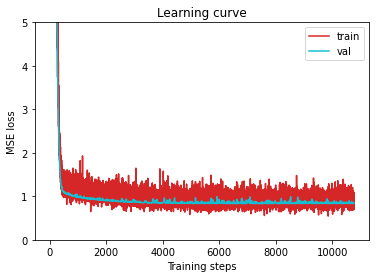

In [59]:
def plot_learning_curve(loss_record):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['valid'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['valid'], c='tab:cyan', label='val')
    plt.ylim(0.0, 5.)
    # plt.xlim(11000, 11600)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve')
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()


plot_learning_curve(loss_record)

## Prediction

This block predicts the value for testing set `test_set`

In [60]:
# delete the last (but not always the best) model
del model

# initialize model
model = Net(train_set.dataset.dim).to(device)

# load the best model save in "./model.pth"
model.load_state_dict(torch.load('./model.pth', map_location='cpu'))

# predicting
model.eval()
preds = []

for x in test_set:
    x = x.to(device)
    with torch.no_grad():
        pred = model(x)
        preds.append(pred.detach().cpu())

preds = torch.cat(preds, dim=0).numpy()

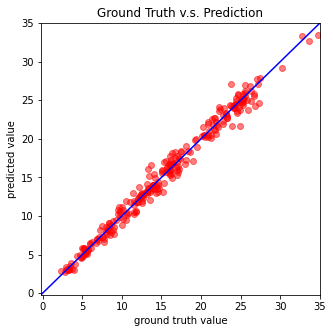

In [61]:
plot_pred(valid_set, model, device)

## Saving results
Save the prediction to `pred.csv`

In [62]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fout:
        writer = csv.writer(fout)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

# preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv') 

Saving results to pred.csv


# Appendix

## Choose features 

I check the correlation matrix to have columns having high correlation with the target, the positive cases in the third day.

In [63]:
with open('./covid.train.csv', 'r') as fin:
    data = list(csv.reader(fin))
    data = np.array(data[1:])[:, 1:].astype(float) # convert
    

In [64]:
cor_vec   = np.corrcoef(data, rowvar=False)[:, -1]
high_cols = np.where(cor_vec > 0.75)

In [65]:
high_cols

(array([40, 41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79, 93]),)

In [66]:
cor_vec

array([ 0.06347943, -0.1526818 , -0.16209655,  0.03070594, -0.20829081,
       -0.13146005, -0.22702296, -0.12083396, -0.05194778,  0.17536543,
       -0.0376707 , -0.02187608,  0.1239483 ,  0.08296595, -0.12546823,
       -0.00658784, -0.20925335, -0.2661426 , -0.10064945, -0.06410969,
        0.23968949,  0.17028676,  0.15800597,  0.17623299, -0.05649202,
        0.00211599, -0.11825057,  0.03263958,  0.18216512,  0.23714868,
       -0.10559856,  0.15116821, -0.08190996,  0.07478468,  0.15747721,
        0.16561899,  0.0554743 , -0.11348231,  0.05894526,  0.01346946,
        0.8385042 ,  0.83052714,  0.87972361,  0.86993839, -0.06953061,
       -0.09730256,  0.03486457, -0.41042975, -0.15794454, -0.2521246 ,
       -0.052473  , -0.44836029,  0.17329459,  0.03768912,  0.08218167,
        0.26221095,  0.47546201,  0.98116473,  0.83822394,  0.82919959,
        0.87943787,  0.86927771, -0.06560047, -0.10040736,  0.03792996,
       -0.4127048 , -0.15912122, -0.25571351, -0.05807917, -0.44